In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import sys
print(sys.path)
path_name = "/Users/garciaj42/code/MLFinance/claude"
sys.path.insert(0, path_name)
sys.path.insert(0, "/Users/garciaj42/code/MLFinance")

['/Users/garciaj42/code/MLFinance', '/Users/garciaj42/code/MLFinance/claude', '/Users/garciaj42/code/MLFinance', '/Users/garciaj42/code/MLFinance/claude', '/Users/garciaj42/code/MLFinance', '/Users/garciaj42/code/MLFinance/claude', '/Users/garciaj42/code/MLFinance/claude/notebooks', '/Users/garciaj42/code/MLFinance/claude/notebooks', '/Users/garciaj42/code/MLFinance', '/opt/homebrew/Cellar/python@3.9/3.9.19_1/Frameworks/Python.framework/Versions/3.9/lib/python39.zip', '/opt/homebrew/Cellar/python@3.9/3.9.19_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9', '/opt/homebrew/Cellar/python@3.9/3.9.19_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/lib-dynload', '', '/opt/homebrew/lib/python3.9/site-packages', '/opt/homebrew/lib/python3.9/site-packages/IPython/extensions', '/opt/homebrew/lib/python3.9/site-packages/setuptools/_vendor', '/Users/garciaj42/.ipython']


In [46]:
from claude.feature_storage import FeatureStorage
from claude.claude import create_global_market_factor
import pandas as pd

data = pd.read_parquet(path_name + "/Data/financial_features.parquet")
data.reset_index(inplace=True, drop=True)
data.index = data['date_time']
# data.drop(['GDP', 'CPIAUCSL', 'RSAFS', '^GSPC', 'SPY', 'SI=F'], axis = 1, inplace=True)
# 'stoch_k', 'mfi', 'stoch_d', 'rsi', 'emv', 'adx',

# Create the factor
# global_market_factor = create_global_market_factor(data)

# Add it back to your dataset
# data['global_market_factor'] = global_market_factor

# You can now drop the original indices if desired
# data.drop(['^AXJO', '^GDAXI', '^FTSE'], axis=1, inplace=True)

In [47]:
data

,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value,V_MOM_10_20,PR_INT_20,CMMA_10_252,RSI_20,MACD_10_100_5,REACT_10_8,LINTRND_10,CVR_20_5,PCO_10_5,STO_20_1,PPO_10_100_5,NOBV_20,SR_14_14_10,MF_21,AROON_DN_100,AROON_DF_100,MADIFF_10_100
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-04-21 03:53:00,2015-04-21 03:53:00,11.0,861.924378,864.265522,345.176602,864.590770,23121.75,18934.25,11.0,4.859070e+07,-6.026192,50.0,0.012086,76.694238,1.242970,49.825466,25.792953,0.0,40.673441,95.767943,0.388608,15.844383,88.054458,0.264632,32.0,68.0,32.815992
2015-04-21 04:02:00,2015-04-21 04:02:00,9.0,864.297240,863.665437,367.099275,862.946916,18939.75,4209.25,9.0,3.985239e+07,-8.222753,50.0,0.007328,70.996189,1.410604,49.329557,25.452101,0.0,42.222876,95.305969,0.349764,13.154653,84.865963,0.224953,31.0,68.0,34.181838
2015-04-21 04:47:00,2015-04-21 04:47:00,9.0,861.828497,861.463410,359.908055,860.828976,18919.25,4204.75,9.0,3.976354e+07,-20.708723,50.0,-0.002772,62.740179,0.087442,13.794447,0.083626,0.0,13.382829,91.216137,0.019828,4.364905,59.284062,0.120884,26.0,68.0,37.826985
2015-04-21 05:31:00,2015-04-21 05:31:00,15.0,860.917334,860.596183,356.527598,856.706215,31494.50,12600.25,15.0,6.611853e+07,-18.926646,-50.0,-0.011879,47.126273,-1.949611,-17.882916,-14.750544,0.0,35.931991,80.959588,-0.282512,11.428710,33.158802,0.207877,23.0,68.0,34.954503
2015-04-21 06:02:00,2015-04-21 06:02:00,14.0,856.954277,858.677792,357.558051,859.254610,29391.00,20995.00,14.0,6.169224e+07,-15.162994,50.0,-0.004197,53.124178,-2.263552,-7.445548,-17.317093,0.0,16.882216,76.431477,-0.312190,3.241766,26.201212,0.162327,21.0,68.0,30.870613
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-13 15:49:00,2024-11-13 15:49:00,17.0,2523.273001,2509.156266,1036.495804,2526.915404,102961.00,54755.50,17.0,6.235166e+08,11.617011,50.0,0.001272,52.832550,0.145765,13.711951,0.267482,0.0,33.647607,60.808667,0.183960,25.193377,42.923190,0.095651,30.0,59.0,6.130398
2024-11-13 16:02:00,2024-11-13 16:02:00,13.0,2521.871933,2502.293927,1028.655802,2449.327446,78857.00,24322.25,13.0,4.783199e+08,10.472345,50.0,-0.001580,47.990212,-0.532213,-4.784779,-0.018938,0.0,42.672182,42.639568,-0.561774,25.877770,35.675931,0.014083,29.0,59.0,5.832773
2024-11-13 16:14:00,2024-11-13 16:14:00,12.0,2449.244763,2503.234503,1029.818291,2526.202253,72430.50,54374.50,12.0,4.371449e+08,9.621430,50.0,0.001073,52.494696,0.051447,16.761836,-0.006449,0.0,47.302735,56.603174,0.088853,25.257490,40.462073,0.093994,28.0,59.0,6.618810


In [49]:
from claude.train_model import build_model

model = build_model(features=data, use_cache=False, path=path_name + "/Data")

Volatility stats:
count    148224.000000
mean          0.015754
std           0.008440
min           0.001744
25%           0.010253
50%           0.014097
75%           0.018443
max           0.062479
Name: close, dtype: float64

Number of non-null values: 148224
Number of events after filtering: 147985
Sample of target values: date_time
2015-04-27 02:05:00    0.005021
2015-04-27 03:00:00    0.005021
2015-04-27 03:17:00    0.005021
2015-04-27 03:32:00    0.005021
2015-04-27 03:43:00    0.005021
Name: close, dtype: float64
T_events length: 148287
Beginning triple_barrier_events at time 2025-02-13 18:36:38.080689
triple_barrier_events
147900
                                     t1      trgt  pt  sl
date_time                                                
2015-04-27 02:05:00 2015-04-27 15:15:00  0.005021   2   1
2015-04-27 03:00:00 2015-04-27 14:43:00  0.005021   2   1
2015-04-27 03:17:00 2015-04-27 15:15:00  0.005021   2   1
2015-04-27 03:32:00 2015-04-27 10:03:00  0.005021   2   1
201

In [50]:
model

Model(triple_barrier_events=                                     t1      trgt  pt  sl  side       ret
date_time                                                                
2015-04-27 02:05:00 2015-04-27 15:15:00  0.005021   2   1    -1 -0.032094
2015-04-27 03:00:00 2015-04-27 14:43:00  0.005021   2   1    -1 -0.010405
2015-04-27 03:17:00 2015-04-27 15:15:00  0.005021   2   1    -1 -0.029931
2015-04-27 03:32:00 2015-04-27 10:03:00  0.005021   2   1     1  0.010733
2015-04-27 03:43:00 2015-04-27 15:15:00  0.005021   2   1    -1 -0.028909
...                                 ...       ...  ..  ..   ...       ...
2024-11-13 14:49:00 2024-11-13 15:20:00  0.014469   2   1     1  0.030788
2024-11-13 15:20:00 2024-11-13 15:32:00  0.014469   2   1    -1 -0.029567
2024-11-13 15:32:00 2024-11-13 15:49:00  0.014469   2   1     1  0.031218
2024-11-13 15:49:00 2024-11-13 16:02:00  0.014469   2   1    -1 -0.030705
2024-11-13 16:02:00 2024-11-13 16:14:00  0.014469   2   1     1  0.031386

[147900 r

In [51]:
from claude.feature_matrix_analyzer import FeatureAnalyzer
from train_model import build_model

# Run analysis
analyzer = FeatureAnalyzer(model.X_clean, model.y_side)
analyzer.analyze_and_report()


=== Feature Matrix Analysis Report ===

Dataset Overview:
- Samples: 108195
- Features: 17
- Samples-to-features ratio: 6364.41

Identified Issues:

HIGH Severity Issues:

Feature(s): PR_INT_20
Issue Type: low_variance
Details: Only 3 unique values in 108195 samples
Suggested Action: Consider removing this near-constant feature

Feature(s): CVR_20_5
Issue Type: low_variance
Details: Only 1 unique values in 108195 samples
Suggested Action: Consider removing this near-constant feature

Feature(s): AROON_DN_100
Issue Type: low_variance
Details: Only 101 unique values in 108195 samples
Suggested Action: Consider removing this near-constant feature

Feature(s): AROON_DF_100
Issue Type: low_variance
Details: Only 201 unique values in 108195 samples
Suggested Action: Consider removing this near-constant feature

MEDIUM Severity Issues:

Feature(s): MACD_10_100_5, REACT_10_8
Issue Type: high_correlation
Details: Correlation coefficient: 0.808
Suggested Action: Consider removing one of these f

In [52]:
from validate import _split_data

X_train, X_test = _split_data(model.X_clean, "2023-01-01")
y_train, y_test = _split_data(model.y_size, "2023-01-01")

First date in data: 2015-04-27 02:05:00
Last date in data: 2024-11-13 16:02:00
Split date: 2023-01-01 00:00:00
Training samples: 79806, Testing samples: 28389
First date in data: 2015-04-27 02:05:00
Last date in data: 2024-11-13 16:02:00
Split date: 2023-01-01 00:00:00
Training samples: 79806, Testing samples: 28389


In [53]:
pd.set_option('display.max_columns', 100)
X_train

,V_MOM_10_20,PR_INT_20,CMMA_10_252,RSI_20,MACD_10_100_5,REACT_10_8,LINTRND_10,CVR_20_5,PCO_10_5,STO_20_1,PPO_10_100_5,NOBV_20,SR_14_14_10,MF_21,AROON_DN_100,AROON_DF_100,MADIFF_10_100
date_time,,,,,,,,,,,,,,,,,
2015-04-27 02:05:00,8.936187,50.0,0.005549,59.748442,0.384487,5.253606,0.757704,0.0,1.234051,66.614029,0.030651,17.392599,57.640723,0.348675,44.0,5.0,14.979934
2015-04-27 03:00:00,8.701437,50.0,0.007537,61.848345,1.111221,8.141180,8.295259,0.0,40.660119,82.602771,0.102269,18.691934,66.740937,0.375653,40.0,60.0,16.632403
2015-04-27 03:17:00,8.207374,50.0,-0.002654,49.700143,0.043896,0.000000,2.527085,0.0,48.880190,58.772218,0.018948,7.020045,56.800917,0.272326,39.0,61.0,16.061542
2015-04-27 03:32:00,7.758288,50.0,-0.016249,37.935115,-2.205963,-31.923018,-0.223093,0.0,49.989155,39.181479,-0.181835,6.204181,46.473478,0.170727,38.0,61.0,13.366783
2015-04-27 03:43:00,6.663903,50.0,-0.006481,46.007412,-2.242313,-17.251891,-1.739917,0.0,49.999564,35.798405,-0.186563,4.727649,44.192238,0.226981,37.0,61.0,12.097018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-29 15:53:00,-11.635862,-50.0,0.000886,60.154865,-0.857535,-0.415155,-0.615025,0.0,-10.181772,35.326389,-0.221160,-8.080194,16.845640,-0.246524,0.0,88.0,49.754124
2022-12-30 14:12:00,3.522351,-50.0,-0.013209,35.792401,-2.631759,-41.602778,-39.697221,0.0,37.930947,26.009823,-0.445840,-15.054890,39.764789,-0.267385,96.0,-89.0,-41.541481
2022-12-30 14:24:00,4.371334,-50.0,-0.008049,38.248236,-2.388614,-35.122917,-35.792157,0.0,39.138623,23.054167,-0.414941,-4.590879,37.199551,-0.200635,95.0,-89.0,-42.995770


In [54]:
X_test

,V_MOM_10_20,PR_INT_20,CMMA_10_252,RSI_20,MACD_10_100_5,REACT_10_8,LINTRND_10,CVR_20_5,PCO_10_5,STO_20_1,PPO_10_100_5,NOBV_20,SR_14_14_10,MF_21,AROON_DN_100,AROON_DF_100,MADIFF_10_100
date_time,,,,,,,,,,,,,,,,,
2023-01-02 19:24:00,2.727954,-50.0,-0.005921,56.303577,-1.203974,-2.712207,-29.636424,0.0,32.700065,52.892537,-0.199911,18.630248,23.722793,-0.089627,68.0,23.0,35.634287
2023-01-02 19:56:00,-0.511223,-50.0,-0.007913,49.983893,-2.606297,-7.237671,-25.199488,0.0,-31.763707,22.025594,-0.401999,-7.822120,11.242284,-0.264204,64.0,23.0,28.241294
2023-01-02 20:03:00,-1.018990,-50.0,-0.012387,45.231126,-3.811986,-21.223906,-30.230925,0.0,-15.735045,14.683729,-0.585912,-18.457443,9.198232,-0.325259,63.0,23.0,25.017352
2023-01-02 20:24:00,0.918207,-50.0,-0.014902,40.533523,-5.359133,-25.493583,-41.380601,0.0,-9.507834,7.584303,-0.827116,-32.619750,6.157494,-0.423710,61.0,23.0,16.913456
2023-01-02 20:44:00,2.890470,-50.0,-0.006627,44.487123,-4.404394,-14.935336,-42.346180,0.0,-18.382614,8.523780,-0.683544,-18.541905,9.213911,-0.216669,59.0,23.0,9.800226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-13 14:49:00,11.746546,-50.0,-0.001575,47.870473,-0.508308,-4.413299,-0.094987,0.0,29.869475,47.093174,-0.553531,22.569400,35.058035,-0.001745,34.0,59.0,6.006353
2024-11-13 15:20:00,12.077864,50.0,0.001240,53.278911,0.360393,-1.789255,0.069824,0.0,26.032891,68.052378,0.437234,31.249160,45.828315,0.102212,32.0,59.0,6.543936
2024-11-13 15:32:00,10.549750,50.0,-0.001322,47.983452,-0.377553,-24.644565,0.146842,0.0,36.096069,48.199302,-0.396548,24.341834,37.811672,0.096935,31.0,59.0,5.211118


In [ ]:
y_train

date_time
2020-02-14 04:24:00    0.0
2020-02-14 07:42:00    1.0
2020-02-14 11:08:00    1.0
2020-02-14 14:30:00    1.0
2020-02-17 03:41:00    1.0
                      ... 
2022-12-22 07:12:00    0.0
2022-12-22 07:17:00    0.0
2022-12-22 07:40:00    0.0
2022-12-22 07:48:00    0.0
2022-12-22 08:10:00    0.0
Name: label, Length: 37893, dtype: float64

In [ ]:
y_test

date_time
2023-01-02 18:22:00    1.0
2023-01-02 18:35:00    1.0
2023-01-02 19:46:00    1.0
2023-01-02 19:56:00    1.0
2023-01-02 20:14:00    1.0
                      ... 
2024-11-13 02:53:00    1.0
2024-11-13 03:11:00    1.0
2024-11-13 03:17:00    1.0
2024-11-13 06:45:00    1.0
2024-11-13 07:44:00    1.0
Name: label, Length: 26132, dtype: float64

In [55]:
from FinancialMachineLearning.cross_validation.cross_validation import get_train_times, get_embargo_times

train_times, test_times = model.triple_barrier_events.loc[:'2022'], model.triple_barrier_events.loc['2022':]

In [56]:
# train_times = get_train_times(train_times['t1'], test_times['t1'])

In [19]:
# train_times.head()

In [57]:
from FinancialMachineLearning.cross_validation.cross_validation import PurgedKFold

purged_k_fold = PurgedKFold(
    n_splits = 10,
    samples_info_sets = model.triple_barrier_events['t1'].loc[X_train.index],
    pct_embargo = 0.01
)

In [58]:
from FinancialMachineLearning.cross_validation.cross_validation import cross_val_score
from sklearn.metrics import log_loss

cross_validation_score = cross_val_score(
    classifier = model.fit_size_model,
    X = X_train,
    y = y_train,
    sample_weight = model.avg_uniq.loc[X_train.index].to_numpy().reshape(1, -1)[0],
    cv_gen = purged_k_fold,
    scoring = log_loss
)

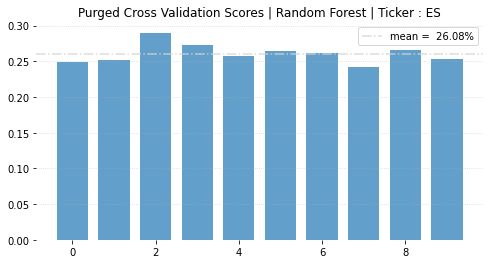

In [59]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize = (8, 4))
ax.bar(
    range(10),
    -cross_validation_score,
    width = 0.75,
    alpha = 0.7,
    edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5)
plt.axhline(
    y = np.mean(-cross_validation_score),
    ls = '-.',
    color = 'lightgray',
    alpha = 0.8,
    label = f'mean = {np.mean(-cross_validation_score) * 100 : .2f}%'
)
plt.legend()
plt.title('Purged Cross Validation Scores | Random Forest | Ticker : ES')
plt.show()

In [60]:
samples_info_sets = model.triple_barrier_events['t1'].loc[X_train.index]

In [61]:
from FinancialMachineLearning.cross_validation.combinatorial import CombinatorialPurgedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from claude.train_model import _train_model

comb_purge_fold = CombinatorialPurgedKFold(
    n_splits = 5,
    n_test_splits = 2, 
    samples_info_sets = samples_info_sets, 
    pct_embargo = 0.15
)

for train_indices, test_indices in comb_purge_fold.split(X_train, y_train):
    X_train_valid, X_test_valid = X_train.iloc[train_indices], X_train.iloc[test_indices]
    y_train_valid, y_test_valid = y_train.iloc[train_indices], y_train.iloc[test_indices]
    
    # forest_fit, forest = _train_model(triple_barrier_events=None, X=X_train_valid, y=y_train_valid, avg_uniqueness=model.avg_uniq, combined_weights=model.combined_weights)

    clf = RandomForestClassifier(random_state = 42)
    clf.fit(X_train_valid, y_train_valid)
    y_pred = clf.predict(X_test_valid)
    accuracy = accuracy_score(y_test_valid, y_pred)
    print(f'Accuracy: {accuracy:.4f}')



Accuracy: 0.9845
Accuracy: 0.9769
Accuracy: 0.9872
Accuracy: 0.9831
Accuracy: 0.9747
Accuracy: 0.9848
Accuracy: 0.9810
Accuracy: 0.9776
Accuracy: 0.9737
Accuracy: 0.9840


In [62]:
from sklearn.ensemble import RandomForestClassifier
from FinancialMachineLearning.sample_weights.bootstrapping import *

class SequentialRandomForestClassifier(RandomForestClassifier):
    def _generate_sample_indices(self, random_state, n_samples):
        """Generate bootstrap sample indices with sequential bootstrap method."""
        random_instance = random_state  # get the RandomState instance
        
        ind_mat = get_indicator_matrix(
            model.triple_barrier_events.index.to_series(),
            model.triple_barrier_events['t1']
        )
        
        sample_indices = seq_bootstrap(ind_mat, n_samples)
        
        return sample_indices

In [63]:
forest = SequentialRandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    random_state = 42,
    n_estimators = 100,
    max_features = 3, # early stopping
    min_weight_fraction_leaf = 0.05, # early stopping
    oob_score = True
)

forest_fit = forest.fit(
    X = X_train, 
    y = y_train, 
    sample_weight = model.avg_uniq.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [64]:
forest_fit.oob_score_

0.9714808410395208

In [65]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')

y_prob = forest_fit.predict_proba(X_test)[:, 1]
y_pred = forest_fit.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')



Accuracy: 0.9807319736517666


In [67]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.04      0.03      0.04       342
         1.0       0.99      0.99      0.99     28047

    accuracy                           0.98     28389
   macro avg       0.52      0.51      0.51     28389
weighted avg       0.98      0.98      0.98     28389



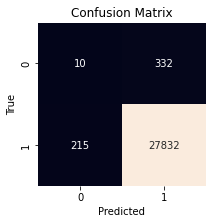

In [68]:
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

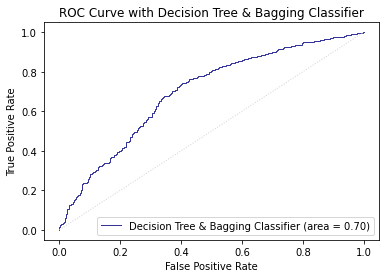

In [69]:
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'Decision Tree & Bagging Classifier (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8, lw = 1)
plt.plot([0, 1], [0, 1], color = 'lightgray', ls = ':', lw = 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Decision Tree & Bagging Classifier')
plt.grid(False)
plt.legend()
plt.show()

In [33]:
from sklearn.ensemble import BaggingClassifier

random_forest_weak = RandomForestClassifier(
    n_estimators = 1,
    criterion = 'entropy',
    bootstrap = False,
    class_weight = 'balanced_subsample',
    min_weight_fraction_leaf = 0.05,
    max_features = .2,
    random_state = 42
)
forest_bagging = BaggingClassifier(
    base_estimator = random_forest_weak,
    n_estimators = 1000,
    max_samples = model.avg_uniq.loc[X_train.index].mean()[0],
    max_features = 1,
    random_state = 42
)
forest_bagging_fit = forest_bagging.fit(
    X = X_train, 
    y = y_train,
    sample_weight = model.avg_uniq.loc[X_train.index].to_numpy().reshape(1, -1)[0]
)

In [ ]:
y_prob = forest_bagging_fit.predict_proba(X_test)[:, 1]
y_pred = forest_bagging_fit.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9823970610745446


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       460
         1.0       0.98      1.00      0.99     25672

    accuracy                           0.98     26132
   macro avg       0.49      0.50      0.50     26132
weighted avg       0.97      0.98      0.97     26132



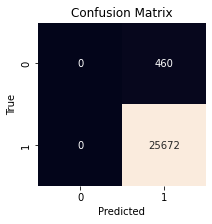

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (3, 3))
sns.heatmap(cm, annot = True, fmt = 'd', cbar = False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

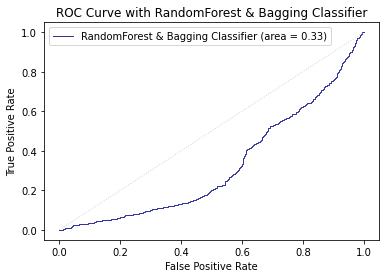

In [ ]:
roc_auc = auc(fpr, tpr)

plt.figure(figsize = (6, 4))
plt.plot(fpr, tpr, label = 'RandomForest & Bagging Classifier (area = {:.2f})'.format(roc_auc), color = 'navy', alpha = 0.8, lw = 1)
plt.plot([0, 1], [0, 1], color = 'lightgray', ls = ':', lw = 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with RandomForest & Bagging Classifier')
plt.grid(False)
plt.legend()
plt.show()

In [ ]:
from FinancialMachineLearning.cross_validation.combinatorial import CombinatorialPurgedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from claude.train_model import _train_model

comb_purge_fold = CombinatorialPurgedKFold(
    n_splits = 5,
    n_test_splits = 2, 
    samples_info_sets = samples_info_sets, 
    pct_embargo = 0.15
)

for train_indices, test_indices in comb_purge_fold.split(X_train, y_train):
    X_train_valid, X_test_valid = X_train.iloc[train_indices], X_train.iloc[test_indices]
    y_train_valid, y_test_valid = y_train.iloc[train_indices], y_train.iloc[test_indices]
    
    # forest_fit, forest = _train_model(triple_barrier_events=None, X=X_train_valid, y=y_train_valid, avg_uniqueness=model.avg_uniq, combined_weights=model.combined_weights)
    
    # forest = SequentialRandomForestClassifier(
    #     criterion = 'entropy',
    #     class_weight = 'balanced_subsample',
    #     random_state = 42,
    #     n_estimators = 500,
    #     max_features = 'sqrt',  # Changed from 3 since you have 38 features
    #     max_depth = 10,        # Add depth limit
    #     min_samples_split = 20, # Add minimum split size
    #     min_weight_fraction_leaf = 0.05, # early stopping
    #     oob_score = True
    # )

    # forest_fit = forest.fit(
    #     X = X_train_valid, 
    #     y = y_train_valid, 
    #     sample_weight = model.avg_uniq.loc[X_train_valid.index].to_numpy().reshape(1, -1)[0]
    # )
    
    # y_pred = forest_fit.predict(X_test_valid)
    # accuracy = accuracy_score(y_test_valid, y_pred)
    # print(f'Accuracy: {accuracy:.4f}')

    clf = RandomForestClassifier(random_state = 42)
    clf.fit(X_train_valid, y_train_valid)
    y_pred = clf.predict(X_test_valid)
    accuracy = accuracy_score(y_test_valid, y_pred)
    print(f'Accuracy: {accuracy:.4f}')



Accuracy: 0.9548
Accuracy: 0.9687
Accuracy: 0.9570
Accuracy: 0.9570
Accuracy: 0.9798
Accuracy: 0.9681
Accuracy: 0.9681
Accuracy: 0.9819
Accuracy: 0.9820
Accuracy: 0.9703


In [201]:
forest = SequentialRandomForestClassifier(
    criterion = 'entropy',
    class_weight = 'balanced_subsample',
    random_state = 42,
    n_estimators = 500,
    max_features = 'sqrt',  # Changed from 3 since you have 38 features
    max_depth = 15,        # Add depth limit
    min_samples_split = 20, # Add minimum split size
    min_weight_fraction_leaf = 0.05, # early stopping
    oob_score = True
)

from sklearn.model_selection import validation_curve
# Test different max_depth values for example
param_range = [5, 10, 15, 20, 25]
train_scores, test_scores = validation_curve(forest, X_train, y_train, 
                                           param_name="max_depth", 
                                           param_range=param_range)


KeyboardInterrupt: 

In [ ]:
train_scores

In [ ]:
test_scores